<a href="https://colab.research.google.com/github/vinitkhemka/NLPudemy/blob/main/moviewreview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install transformers
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import torch
torch.cuda.is_available()

True

In [17]:

##Before running this , put kaggle.json token in /root/.kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api=KaggleApi()
api.authenticate()

In [18]:
import os
os.getcwd()

'/content'

In [19]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip',
                              path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip',
                              path='./')

100%|██████████| 494k/494k [00:01<00:00, 483kB/s]


100%|██████████| 1.28M/1.28M [00:01<00:00, 924kB/s]

In [20]:
import zipfile
with zipfile.ZipFile('./train.tsv.zip') as zipref:
  zipref.extractall('./')

with zipfile.ZipFile('./test.tsv.zip') as zipref:
  zipref.extractall('./')

In [21]:
import pandas as pd

In [22]:
data=pd.read_table("./train.tsv",sep='\t')

In [23]:
data.head(10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


<AxesSubplot:>

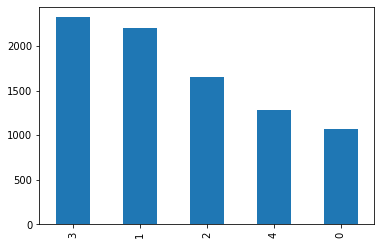

In [24]:
df=data.drop_duplicates(subset='SentenceId',keep='first')
df['Sentiment'].value_counts().plot(kind='bar')

In [25]:
seq_len=512
num_samples=len(df)

In [26]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')

In [27]:
tokens=tokenizer(df['Phrase'].to_list(),max_length=seq_len,truncation=True,
                 padding='max_length',add_special_tokens=True,return_tensors='np')

In [28]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [29]:
tokens['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
import numpy as np
with open('token_input.npy','wb') as f:
  np.save(f,tokens['input_ids'])

In [31]:
import numpy as np
with open('token_attention_mask.npy','wb') as f:
  np.save(f,tokens['attention_mask'])

In [32]:
from sklearn.preprocessing import OneHotEncoder

In [33]:
ohc=OneHotEncoder()
sentiment_enc=ohc.fit_transform(df['Sentiment'].values.reshape(-1,1))

In [35]:
sentiment_enc_arr=sentiment_enc.toarray()

In [36]:
with open("sentiment.npy",'wb') as f:
  np.save(f,sentiment_enc_arr)

In [37]:
with open('sentiment.npy','rb') as f:
  sentiment_enc_arr=np.load(f)

In [38]:
import tensorflow as tf

In [39]:
dataset=tf.data.Dataset.from_tensor_slices((tokens['input_ids'],tokens['attention_mask'],sentiment_enc_arr))

In [40]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
def map_func(input_ids,mask,labels):
  return {'input_ids':input_ids,
          'mask':mask},labels

In [42]:
dataset=dataset.map(map_func)

In [43]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [44]:
batch_size=32
dataset=dataset.shuffle(10000).batch(batch_size,drop_remainder=True)

In [45]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 512), dtype=tf.int64, name=None), 'mask': TensorSpec(shape=(32, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>

In [46]:
split=0.9
size_train=int(len(df['Sentiment'])/batch_size * split)

In [47]:
train_ds=dataset.take(size_train)
val_ds=dataset.skip(size_train)

In [48]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(32, 512), dtype=tf.int64, name=None),
  'mask': TensorSpec(shape=(32, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))

In [49]:
tf.data.Dataset.save(train_ds,'train')
tf.data.Dataset.save(val_ds,'val')

In [50]:
from transformers import TFAutoModel

In [51]:
bert=TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [52]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [53]:
#inputs
input_ids=tf.keras.layers.Input(shape=(512,),name='input_ids',dtype='int64')
mask=tf.keras.layers.Input(shape=(512,),name='mask',dtype='int64')

In [54]:
#tranformer
embeddings=bert.bert(input_ids,attention_mask=mask)[1]

In [55]:
embeddings

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>

In [56]:
x=tf.keras.layers.Dense(1024,activation='relu')(embeddings)
y=tf.keras.layers.Dense(5,activation='softmax')(x)

In [57]:
model=tf.keras.Model(inputs=[input_ids,mask],outputs=y)

In [58]:
model.layers[2].trainable=False

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 mask (InputLayer)              [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'mask[0][0]']                   
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [60]:
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
loss=tf.keras.losses.CategoricalCrossentropy()
metrics=tf.keras.metrics.CategoricalAccuracy('accuracy')


In [61]:
model.compile(optimizer=optimizer,loss=loss,metrics=[metrics])

In [62]:
element_spec=({'input_ids': tf.TensorSpec(shape=(32, 512), dtype=tf.int64, name=None),
  'mask': tf.TensorSpec(shape=(32, 512), dtype=tf.int64, name=None)},
 tf.TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))



In [63]:
history=model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=2)

Epoch 1/2
239/239 [==============================] - 376s 2s/step - loss: 1.5522 - accuracy: 0.2911 - val_loss: 1.5150 - val_accuracy: 0.3137
Epoch 2/2
239/239 [==============================] - 358s 1s/step - loss: 1.5230 - accuracy: 0.3190 - val_loss: 1.5006 - val_accuracy: 0.2905


In [64]:
model.save('bert_classifier')

In [65]:
model=tf.keras.models.load_model('bert_classifier')

In [70]:
test_data=pd.read_csv('test.tsv',sep='\t')
test_data.head()
test_data=test_data.drop_duplicates(subset=['SentenceId'],keep='first')

In [75]:
def prep_data(text,seq_len=512):
  tokens=tokenizer(text,max_length=seq_len,truncation=True,
                 padding='max_length',add_special_tokens=True,return_tensors='tf')
  return ({'input_ids':tokens['input_ids'],
           'mask':tokens['attention_mask']})

In [81]:
probs=model.predict(prep_data('this movie was terrible'))[0]

1/1 [==============================] - 0s 207ms/step


In [82]:
np.argmax(probs)

3

In [86]:
test_data['sentiment']=None

In [ ]:
for i, row in test_data.iterrows():
  token=prep_data(row['Phrase'])
  probs=model.predict(token)[0]
  sentiment=np.argmax(probs)
  test_data.at[i,'Sentiment']=sentiment

1/1 [==============================] - 0s 83ms/step


In [ ]:
test_data